In [27]:
#Code is mostly adopted from this blog post
#https://medium.com/geekculture/price-elasticity-of-demand-using-linear-regression-in-python-part-2-8adb654328e7

In [ ]:
import requests
from requests.auth import HTTPBasicAuth
import numpy as np
import http.client
import requests
import pandas as pd
import json
from pandas.io.json import json_normalize
from datetime import datetime

In [28]:
#Here we use the DefiLlama API to get all of the pools. We will later loop through them
response = requests.get("""https://yields.llama.fi/pools""")
farming_pools = json.loads(response.content)
farming_pools = json_normalize(farming_pools['data'])

<ipython-input-28-654e55cddc53>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  farming_pools = json_normalize(farming_pools['data'])


In [29]:
#Now filter for the pools of interest
usdc_farms = farming_pools[(farming_pools['symbol']=='USDC') & (farming_pools['chain']=='Ethereum')]
usdc_farms = usdc_farms[usdc_farms['apy']>0]
usdc_farms = usdc_farms[usdc_farms['tvlUsd']>10000000]

In [30]:
#Creating an empty data frame to append data to when calling DefiLlama API
usdc_data = pd.DataFrame(columns=['timestamp', 'tvlUsd', 'apy', 'apyBase', 'apyReward', 'il7d','apyBase7d', 'pools'])

In [31]:
for i in usdc_farms['pool']:
  response = requests.get('https://yields.llama.fi/chart/'+str(i))
  erp = json.loads(response.content)
  loop_data = json_normalize(erp['data'])
  loop_data['pools'] = i
  usdc_data = pd.concat([loop_data,usdc_data])

<ipython-input-31-6f4c8019f3e9>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  loop_data = json_normalize(erp['data'])


In [32]:
usdc_data = usdc_data.drop_duplicates()

In [33]:
usdc_data = usdc_data.merge(farming_pools,left_on='pools',right_on='pool',how='inner')

In [34]:
x_pivot = usdc_data.pivot( index = 'timestamp',columns='project', values='apy_x')
x_train = pd.DataFrame(x_pivot.to_records())

In [35]:
y_pivot = usdc_data.pivot( index = 'timestamp',columns='project', values='tvlUsd_x')
y_train = pd.DataFrame(y_pivot.to_records())

In [36]:
points = []
results_values = {
    "name": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
}
#Append x_train with y_train per same product name
for column in x_train.columns[1:]:
    column_points = []
    for i in range(len(x_train[column])):
        if not np.isnan(x_train[column][i]) and not np.isnan(y_train[column][i]):
            column_points.append((x_train[column][i], y_train[column][i]))
    df = pd.DataFrame(list(column_points), columns= ['x_value', 'y_value'])


    #Linear Regression Model
    import statsmodels.api as sm
    x_value = df['x_value']
    y_value = df['y_value']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()
    
    
    #(Null Hypothesis test) Coefficient with a p value less than 0.05
    if result.f_pvalue < 0.05:
        
        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        intercept, slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        tintercept, t_score = result.tvalues
     
        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)    
            
        #Append results into dictionary for dataframe
        results_values["name"].append(column)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        
final_df = pd.DataFrame.from_dict(results_values)
df_elasticity = final_df[['name','price_elasticity','t_score','coefficient_pvalue','slope','price_mean','quantity_mean','intercept']]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versi

In [37]:

def divergent_plot(df, values_column, ylabel, xlabel):

    #Divergent plot
    df['ranking'] = df[values_column].rank( ascending = True).astype(int)
    df.sort_values(values_column, ascending =False, inplace = True)
    plt.figure(figsize = (12,5), dpi = 80)
    plt.hlines(y = df['ranking'] , xmin = 0, xmax = df[values_column], alpha = 0.5, linewidth = 3)
    
    #Add elasticity labels
    for x, y, tex in zip(df[values_column], df['ranking'] , df[values_column]):
        plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':10})
        
    
    # Axis and title
    plt.gca().set(ylabel= ylabel, xlabel= xlabel)
    plt.yticks(df['ranking'])
    plt.title(values_column , fontdict={'size':13})
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()
            
    
    #Adjust Ranking column and print dataframe
    pd.set_option('display.width', 4000)
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    
    df = df.iloc[:,:3]
    df.set_index('ranking', inplace=True)
    display(df)

<ipython-input-37-3c1dad839cde>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ranking'] = df[values_column].rank( ascending = True).astype(int)
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


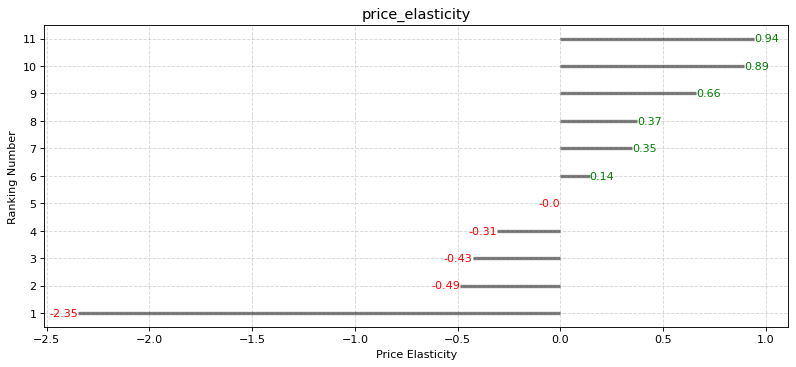

,name,price_elasticity
ranking,,
11,morpho-aave,0.943524
10,compound,0.894603
9,instadapp,0.660358
8,morpho-compound,0.371465
7,ribbon,0.347815
6,across,0.141761
5,goldfinch,-0.000904
4,sherlock,-0.309516
3,euler,-0.427094


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pe_plot = divergent_plot(df_elasticity, 'price_elasticity', 'Ranking Number', 'Price Elasticity')
